# Deploying Python ML models using Containers
# *...in less than 30 min*

![](https://secure.meetupstatic.com/photos/event/5/e/8/3/600_476724195.jpeg)

## Case Study: Docker Containers for fast Object Detection
#### YOLO v3, OpenCV, Databricks and Azure ML Service
- **[Renan Vilas Novas (December 06, 2018)](https://github.com/nansravn/object-detection-opencv)**
- *Deployment inspired by the work of [Arun Ponnusamy (July 16, 2018)](https://github.com/arunponnusamy/object-detection-opencv)*

![](https://docs.microsoft.com/en-us/azure/machine-learning/service/media/concept-model-management-and-deployment/inferencing-targets.png)

# Data Ingestion

In [5]:
import os
import urllib

In [6]:
# Downloading YOLO v3 Configuration File
basedataurl = "https://raw.githubusercontent.com/nansravn/object-detection-opencv/master/references/yolov3.cfg"
datafile = "yolov3.cfg"

datafile_dbfs = os.path.join("/dbfs", datafile)
if os.path.isfile(datafile_dbfs):
    print("found {} at {}".format(datafile, datafile_dbfs))
else:
    print("downloading {} to {}".format(datafile, datafile_dbfs))
    urllib.request.urlretrieve(os.path.join(basedataurl, datafile), datafile_dbfs)

downloading yolov3.cfg to /dbfs/yolov3.cfg

In [7]:
# Deleting the yolov3.cfg file from the dbfs
#dbutils.fs.rm("dbfs:/yolov3.cfg")

In [8]:
# Downloading YOLO v3 Weights (trained on COCO Dataset)
basedataurl = "https://pjreddie.com/media/files"
datafile = "yolov3.weights"

datafile_dbfs = os.path.join("/dbfs", datafile)
if os.path.isfile(datafile_dbfs):
    print("found {} at {}".format(datafile, datafile_dbfs))
else:
    print("downloading {} to {}".format(datafile, datafile_dbfs))
    urllib.request.urlretrieve(os.path.join(basedataurl, datafile), datafile_dbfs)

downloading yolov3.weights to /dbfs/yolov3.weights

In [9]:
# Deleting the yolov3.weights file from the dbfs
#dbutils.fs.rm("dbfs:/yolov3.weights")

In [10]:
## NOTE: AML service deployment currently gets the model from the current working dir
import time
time.sleep(30) # We need to wait a few seconds to be sure that the yolov3.weights file is ready to be copied

for file_name in ["yolov3.weights", "yolov3.cfg"]:
  file_name_dbfs = os.path.join("/dbfs", file_name)

  print("copying " + file_name + " from dbfs to local")
  file_local = "file:" + os.getcwd() + "/" + file_name
  dbutils.fs.cp(file_name, file_local, True)

copying yolov3.weights from dbfs to local
copying yolov3.cfg from dbfs to local

In [11]:
%sh
ls -lh yolo*

-rw-r--r-- 1 root root 8.2K Dec 13 12:26 yolov3.cfg
-rw-r--r-- 1 root root 237M Dec 13 12:26 yolov3.weights

# Step 1: Azure Machine Learning setup

#####Before running this step, you need to be sure that the AML SDK has already been installed with a `pip install`.
If you are using Azure Databricks to run this code, follow the reference below:

- [Configuring the AML PyPI Package on a Databricks Dev Environment](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-environment#azure-databricks)

### AML SDK

In [13]:
import azureml.core as aml
print("azureml-sdk[databricks] // PyPI version:", aml.__version__)

azureml-sdk[databricks] // PyPI version: 1.0.2

### AML Workspace
Reference: [Configuring an AML Environment and generating a config file](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-environment#workspace)

In [15]:
aml_workspace_name = "ws-aml-meetup"
aml_resource_group = "rg-meetup-2nd"
aml_subscription_id = dbutils.secrets.get("meetup-2nd", "subscription_id") #Here I'm using the Databricks Secrets API to protect my Subscription ID
aml_location = "eastus2"

# The aml.Workspace() method loads an already pre-existing Workspace
ws = aml.Workspace(
        workspace_name = aml_workspace_name,
        subscription_id = dbutils.secrets.get("meetup-2nd", "subscription_id"),
        resource_group = aml_resource_group)  

# If you don't have created an AML Service Workspace yet, you can create it with the script below
# ws = aml.Workspace.create(
#          workspace_name = aml_workspace_name,
#          subscription_id = dbutils.secrets.get("meetup-2nd", "subscription_id"),
#          resource_group = aml_resource_group,
#          location = aml_location)

ws.write_config("/dbfs","meetup.json")

Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code AGPN5RH3V to authenticate.
Interactive authentication successfully completed.
Wrote the config file meetup.json to: /dbfs/aml_config/meetup.json

Verifying if the *aml_config* file exists:

In [17]:
%fs
ls dbfs:/aml_config/meetup.json

path,name,size
dbfs:/aml_config/meetup.json,meetup.json,143


In [18]:
# Importing the ML Workspace from the config file
ws = aml.Workspace.from_config("/dbfs/aml_config/meetup.json")

Found the config file in: /dbfs/aml_config/meetup.json

# Step 2: Preparing the requirements to build our Webservice
- **Binary files:** Models or any other kind of configuration files to be imported
- **.py code:** The script with the logic for loading the model and configs, as also the data scoring pipeline
- **.yml requirements:** Package configuration through conda .yml requirements file
- **.dockerfile:** File with additional Docker steps to run when setting up the image

##### Registering the .weights and .cfg of the YOLO Network on the AML Workspace
Reference: [Registering models and config files into the AML Workspace](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-deploy-to-aci#register-a-model-file)

In [21]:
from azureml.core.model import Model

model_config = Model.register(model_path = "yolov3.cfg", # this points to a local file
                        model_name = "yolov3_config", # this is the name the file is registered as
                        description = "Config for a YOLO V3 object detection model",
                        workspace = ws)

Registering model yolov3_config

In [22]:
model_weights = Model.register(model_path = "yolov3.weights", # this points to a local file
                        model_name = "yolov3_weights", # this is the name the file is registered as
                        description = "Weights for a YOLO V3 object detection model",
                        workspace = ws)

Registering model yolov3_weights

##### Creating the .py script
Reference: [Creating the scoring script](https://docs.microsoft.com/en-us/azure/machine-learning/service/tutorial-deploy-models-with-aml#create-scoring-script)

In [24]:
#%%writefile score.py
score_py = """
from azureml.core.model import Model
import json
import numpy as np
import cv2
import urllib

def init():
    from azureml.core.model import Model

    global net, weights_path, config_path, scale, classes, COLORS
    global get_output_layers, draw_prediction
    
    def get_output_layers(net):    
      layer_names = net.getLayerNames()   
      output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
      return output_layers
  
    def draw_prediction(img, class_id, confidence, x, y, x_plus_w, y_plus_h):
      label = str(classes[class_id])
      color = COLORS[class_id]
      cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)
      cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    weights_path = Model.get_model_path('yolov3_weights')
    config_path = Model.get_model_path('yolov3_config')

    scale = 0.00392

    classes = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',\
               'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', \
               'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', \
               'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', \
               'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', \
               'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', \
               'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', \
               'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', \
               'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
        
    COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

    net = cv2.dnn.readNet(weights_path , config_path)

def run(raw_data):
    image_url = json.loads(raw_data)['image_url']

    req = urllib.request.urlopen(image_url)
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    image = cv2.imdecode(arr, -1) # 'Load it as it is'

    Width = image.shape[1]
    Height = image.shape[0]
    
    blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)

    net.setInput(blob)

    outs = net.forward(get_output_layers(net))

    class_ids = []
    confidences = []
    boxes = []
    conf_threshold = 0.5
    nms_threshold = 0.4


    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * Width)
                center_y = int(detection[1] * Height)
                w = int(detection[2] * Width)
                h = int(detection[3] * Height)
                x = center_x - w / 2
                y = center_y - h / 2
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])

    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

    for i in indices:
        i = i[0]
        box = boxes[i]
        x = box[0]
        y = box[1]
        w = box[2]
        h = box[3]
        draw_prediction(image, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))
    return json.dumps(image.tolist())
"""
 
exec(score_py)
 
with open("yolo-score.py", "w") as file:
    file.write(score_py)

##### Creating the .yml requirements file
Reference: [Creating an environment file](https://docs.microsoft.com/en-us/azure/machine-learning/service/tutorial-deploy-models-with-aml#create-environment-file)

In [26]:
%%writefile yolo-env.yml
# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.
# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
  - azureml-defaults==1.0.2
  - opencv-python==3.4.3.18

Writing yolo-env.yml

##### Creating the .dockerfile with additional docker steps for setting up the image
Reference: [Sending additional docker steps to the .image_configuration() method](https://docs.microsoft.com/pt-br/python/api/azureml-core/azureml.core.image.containerimage?view=azure-ml-py#image-configuration-execution-script--runtime--conda-file-none--docker-file-none--schema-file-none--dependencies-none--enable-gpu-none--tags-none--properties-none--description-none-)

In [28]:
%%writefile yolo.dockerfile
RUN apt-get update && apt-get install -y libsm6 libxrender1 libfontconfig1 libxext6 libxrender-dev

Writing yolo.dockerfile

# TL;DR
### 5 required files for the Image Creation:

In [30]:
%sh
ls -lh yolo*

-rw-r--r-- 1 root root 98 Dec 13 12:29 yolo.dockerfile
-rw-r--r-- 1 root root 505 Dec 13 12:29 yolo-env.yml
-rw-r--r-- 1 root root 3.6K Dec 13 12:29 yolo-score.py
-rw-r--r-- 1 root root 8.2K Dec 13 12:26 yolov3.cfg
-rw-r--r-- 1 root root 237M Dec 13 12:26 yolov3.weights

# Step 3: Creating the Image and deploying the Webservice
##### Creating the Image Configuration with the .py, .yml and .dockerfile
Reference: [Configuring the Docker Image](https://docs.microsoft.com/pt-br/azure/machine-learning/service/how-to-deploy-to-aci#configure-an-image)

In [32]:
service_name = "yolo-meetup-ws"
runtime = "python" 
driver_file = "yolo-score.py"
my_conda_file = "yolo-env.yml"
my_docker_file = "yolo.dockerfile"

# image creation
from azureml.core.image import ContainerImage
myimage_config = ContainerImage.image_configuration(execution_script = driver_file, 
                                                    runtime = runtime, 
                                                    conda_file = my_conda_file,
                                                    docker_file = my_docker_file)

##### Creating the Image on the AML Workspace
The image is created with the configuration `myimage_config` and with the registered models/files (`model_weights` and `model_config`)

In [34]:
yolo_image = ContainerImage.create(name = "yolo-meetup-image",
                                   models = [model_weights, model_config],
                                   image_config = myimage_config,
                                   workspace = ws)

# Wait for the create process to complete
yolo_image.wait_for_creation(show_output = True)

Creating image
Running..................................................
SucceededImage creation operation finished for image yolo-meetup-image:6, operation "Succeeded"

##### Setting up a Deployment Environment through the AML SDK
Reference: [Configuring an ACI Deployment Environment through the AML SDK](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-deploy-to-aci#configure-the-aci-container)

In [36]:
from azureml.core.webservice import AciWebservice, Webservice

myaci_config = AciWebservice.deploy_configuration(
                    cpu_cores = 1, 
                    memory_gb = 1, 
                    description = 'ACI for deploying YOLO V3')

##### Deploying the webservice to the Azure Container Instance (ACI)
Reference: [Deploying to ACI](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-deploy-to-aci#option-2-deploy-from-registered-model)

In [38]:
# Webservice creation
service_name = 'yolo-meetup-ws'
yolo_ws_dev = Webservice.deploy_from_image(deployment_config = myaci_config,
                                            image = yolo_image,
                                            name = service_name,
                                            workspace = ws)
yolo_ws_dev.wait_for_deployment(show_output = True)
print(yolo_ws_dev.state)

Creating service
Running........................
SucceededACI service creation operation finished, operation "Succeeded"
Healthy

In [39]:
# Printing the webservice deployment logs
#print(yolo_ws_dev.get_logs())

# Let's test the Webservice!
Reference: [Testing the webservice](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-deploy-to-aci#a-nametest-web-servicetest-the-web-service)

In [41]:
print(yolo_ws_dev.scoring_uri)

http://157.56.182.144:80/score

In [42]:
import matplotlib.pyplot as plt
import cv2

In [43]:
image_url = "https://raw.githubusercontent.com/nansravn/object-detection-opencv/master/dog.jpg"
response = yolo_ws_dev.run(json.dumps({"image_url":image_url}))

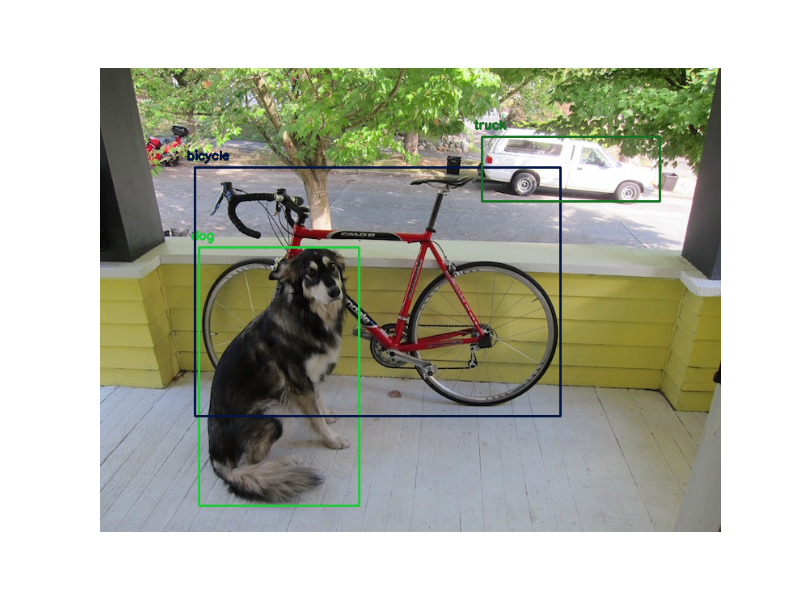

In [44]:
plt.imshow(cv2.cvtColor(np.array(json.loads(response), dtype=np.uint8),cv2.COLOR_BGR2RGB))
plt.axis("off")
display()

### Deleting the Webservice and the ACI resource

In [46]:
# Uncomment this code below to delete the webservice and also the ACI created for the webservice
#yolo_ws_dev.delete()

# Use this code below if the variable yolo_ws_dev is not initialized with the yolo-meetup-ws webservice (i.e. if you terminated the Databricks cluster)
#ws.webservices['yolo-meetup-ws'].delete()

## [OPTIONAL] Deploying to an Azure Kubernetes Service (AKS)
If you need more compute power than an ACI, feel free to deploy the model to an Azure Kubernetes Service (AKS)

For that kind of deployment you will need to generate another type of Deployment Environment:

~~~~python
  from azureml.core.compute import AksCompute, ComputeTarget
  
  prov_config = AksCompute.provisioning_configuration(location='eastus2')

  aks_name = 'aks-meetup' 
  # Create the cluster
  aks_target = ComputeTarget.create(workspace = ws, 
                                    name = aks_name, 
                                    provisioning_configuration = prov_config)

  # Wait for the create process to complete
  aks_target.wait_for_completion(show_output = True)
  print(aks_target.provisioning_state)
  print(aks_target.provisioning_errors)
~~~~

After creating the cluster you can deploy the webservice to the AKS using the same Docker Image we've created before.

~~~~python
  from azureml.core.webservice import Webservice, AksWebservice

  # Set configuration and service name
  aks_config = AksWebservice.deploy_configuration()
  aks_service_name ='yolo-meetup-ws-prod'
  
  # Deploy from image
  yolo_ws_prod = Webservice.deploy_from_image(workspace = ws, 
                                              name = aks_service_name,
                                              image = yolo_image,
                                              deployment_config = aks_config,
                                              deployment_target = aks_target)
  
  # Wait for the deployment to complete
  yolo_ws_prod.wait_for_deployment(show_output = True)
  print(yolo_ws_prod.state)
~~~~
For more documentation about the AKS endpoint, take a look in the documentation below.

Reference: [Deploying models from AML Service to AKS](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-deploy-to-aks)

# What's next?
Reference: [Sending the Docker Image to an AKS Cluster or to the Edge](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-deploy-and-where)

![](https://docs.microsoft.com/en-us/azure/machine-learning/service/media/concept-model-management-and-deployment/deployment-pipeline.png)